In [1]:
%load_ext autoreload
%autoreload 2

# add microvad Python module to path
import sys
sys.path.insert(0, '..')

In [2]:
import pandas
import numpy
import librosa

import microvad
from microvad.datasets import ava

from matplotlib import pyplot as plt

In [3]:

# hyperparameters
hop_length = 1024
time_resolution = float(hop_length)/16000
window_length = 100


In [4]:

def load_annotations(out_dir=''):
    df = ava.load_annotations()
    
    df['path'] = [ ava.file_download_path(f, out_dir=out_dir) for f in df['file'] ]
        
    return df


out_dir = '../data/ava_speech'
annotations = load_annotations(out_dir=out_dir)
annotations

,start,end,label,file,path
clip,,,,,
5BDj0ow5hnA,900.00,905.67,SPEECH_WITH_NOISE,5BDj0ow5hnA.mp4,../data/ava_speech/5BDj0ow5hnA.ogg
5BDj0ow5hnA,905.67,907.40,NO_SPEECH,5BDj0ow5hnA.mp4,../data/ava_speech/5BDj0ow5hnA.ogg
5BDj0ow5hnA,907.40,908.08,SPEECH_WITH_NOISE,5BDj0ow5hnA.mp4,../data/ava_speech/5BDj0ow5hnA.ogg
5BDj0ow5hnA,908.08,908.76,NO_SPEECH,5BDj0ow5hnA.mp4,../data/ava_speech/5BDj0ow5hnA.ogg
5BDj0ow5hnA,908.76,910.15,SPEECH_WITH_NOISE,5BDj0ow5hnA.mp4,../data/ava_speech/5BDj0ow5hnA.ogg
...,...,...,...,...,...
UrsCy6qIGoo,1794.83,1795.55,SPEECH_WITH_NOISE,UrsCy6qIGoo.mkv,../data/ava_speech/UrsCy6qIGoo.ogg
UrsCy6qIGoo,1795.55,1796.56,NO_SPEECH,UrsCy6qIGoo.mkv,../data/ava_speech/UrsCy6qIGoo.ogg
UrsCy6qIGoo,1796.56,1797.07,CLEAN_SPEECH,UrsCy6qIGoo.mkv,../data/ava_speech/UrsCy6qIGoo.ogg


In [5]:
annotations.label.value_counts()

NO_SPEECH            17624
SPEECH_WITH_NOISE    10506
CLEAN_SPEECH          6433
SPEECH_WITH_MUSIC     5311
Name: label, dtype: int64

In [6]:
clip = '5BDj0ow5hnA'
clip

'5BDj0ow5hnA'

In [18]:

def load_audio(path, sr=16000, duration=30*60):
    audio, sr = librosa.load(path, duration=duration, sr=None)
    assert sr == sr
    
    return audio
    

aa = load_audio(annotations.loc[clip]['path'][0])
(aa.shape[0] / 16000) / 60.0
    
#annotation.groupby('path')



30.0

In [7]:
def convert_spec(audio, sr=16000, n_mels=64, hop_length=512):
    
    n_fft = int(2*hop_length)
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
    db = librosa.power_to_db(mels, ref=0.0)
    
    return db

spec = convert_spec(aa, hop_length=hop_length)
spec.shape

NameError: name 'aa' is not defined

In [20]:
def convert_mfcc(audio, sr=16000, n_mfcc=13, hop_length=1024):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)

    return mfcc

mfcc = convert_mfcc(aa, hop_length=hop_length)
mfcc.shape

(13, 28126)

In [21]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

mfcc_2d = PCA(2).fit_transform(RobustScaler().fit_transform(mfcc.T))
mfcc_2d.shape

(28126, 2)

In [23]:

from microvad.preprocessing.preprocessing import make_continious_labels

a = annotations.loc[clip]

l = make_continious_labels(a[a.label != 'NO_SPEECH'], spec.shape[1], time_resolution)
l.event.value_counts()


0    17087
1    11039
Name: event, dtype: int64

In [30]:
l.shape

(28126, 1)

In [28]:
mfcc.shape

(13, 28126)

In [24]:
d = pandas.DataFrame(mfcc_2d, columns=['mfcc.pca1', 'mfcc.pca2'])
d['label'] = l.reset_index()['event']
d

,mfcc.pca1,mfcc.pca2,label
0,2.536433,0.387179,0
1,2.536479,0.387122,0
2,2.536476,0.386969,0
3,2.536476,0.386957,0
4,2.536475,0.386949,0
...,...,...,...
28121,-1.177726,0.289436,1
28122,-1.173064,0.536288,1
28123,-0.855098,-1.275095,1
28124,-1.880860,-0.956207,1


<Axes: xlabel='mfcc.pca1', ylabel='mfcc.pca2'>

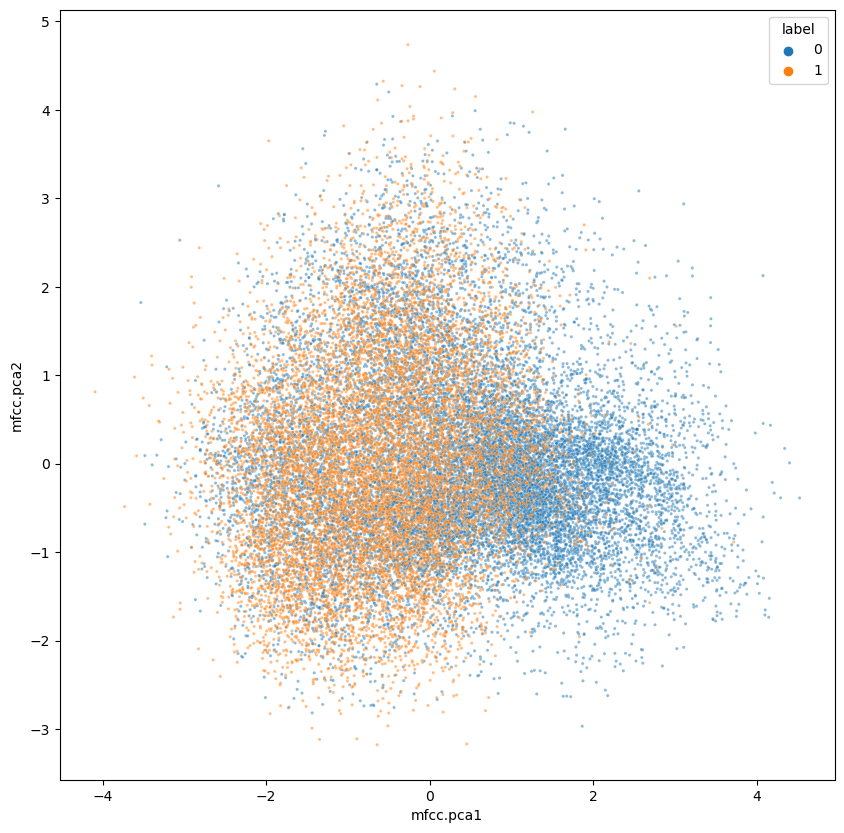

In [25]:
import seaborn
fig, ax = plt.subplots(1, figsize=(10,10))
seaborn.scatterplot(ax=ax, data=d, x='mfcc.pca1', y='mfcc.pca2', hue='label', s=5, alpha=0.5)

<Axes: xlabel='mfcc.pca1', ylabel='mfcc.pca2'>

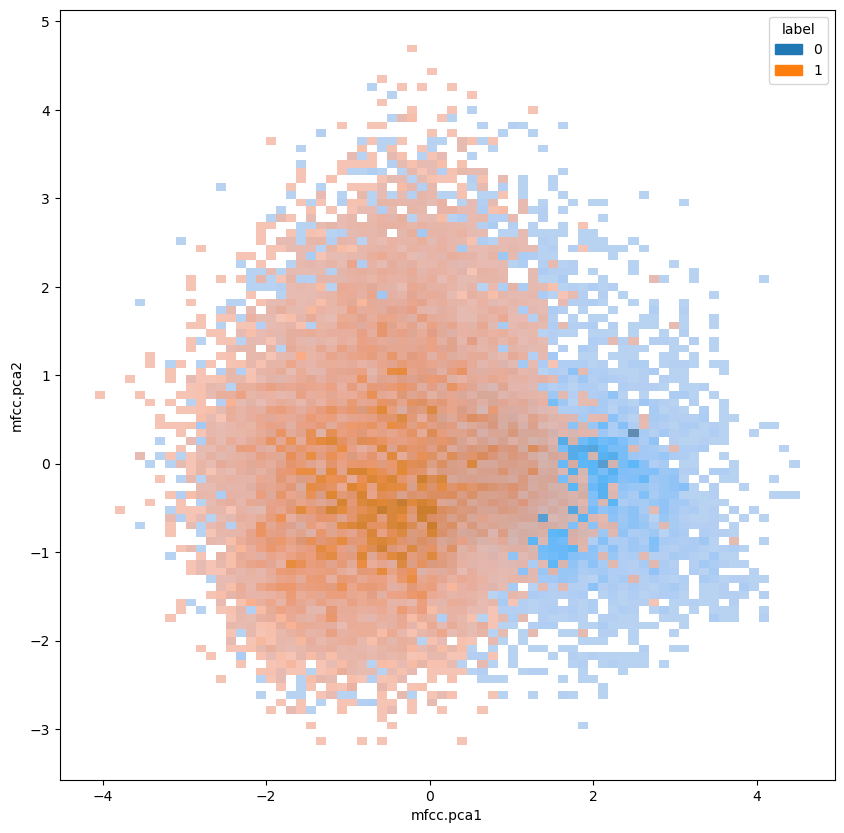

In [26]:
fig, ax = plt.subplots(1, figsize=(10,10))
seaborn.histplot(ax=ax, data=d, x='mfcc.pca1', y='mfcc.pca2', hue='label', alpha=0.8)

In [ ]:
mfcc

In [35]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import get_scorer

est = RandomForestClassifier(n_estimators=10, min_samples_leaf=0.001)

X = mfcc.T
y = l.reset_index()['event']
cross_val_score(est, X=X, y=y, scoring=get_scorer('f1'))



array([0.54801325, 0.50859492, 0.49197861, 0.53869535, 0.28019602])

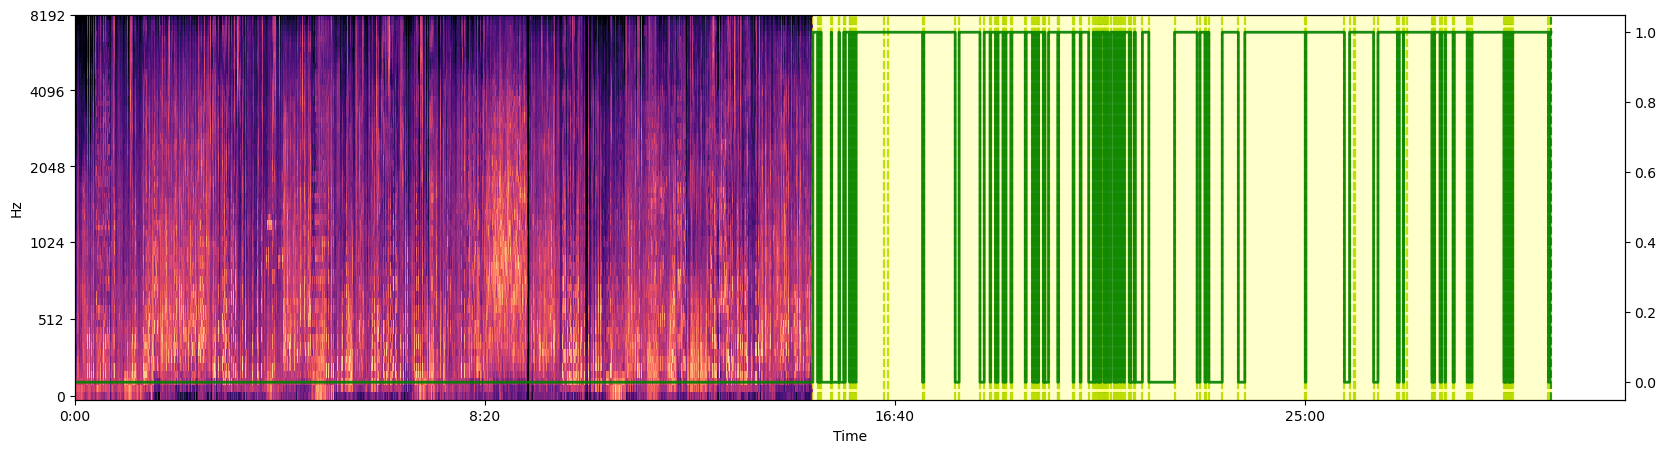

In [37]:
        
from microvad.train.evaluate import plot_spectrogram
    
fig, ax = plt.subplots(1, figsize=(20, 5))
plot_spectrogram(ax, spec, label_activations=l, events=a)
#ax.set_xlim((15.0*60.0, 16*60.0))

#ax.set_xlim((10.0*60.0, 35*60.0))
#ax.set_xlim((10.0*60.0, 11*60.0))

In [39]:

from microvad.preprocessing.preprocessing import compute_windows

windows = pandas.DataFrame({
    'spectrogram': compute_windows(spec, frames=window_length, step=2),
    'labels': compute_windows(l.values.T, frames=window_length, step=2),
    #'file': audio_path,
})
windows['event'] = windows.labels.apply(lambda labels: numpy.any(labels, axis=-1)).astype(int)
windows[windows.event == True].head(5)



,spectrogram,labels,event
start_index,,,
13964,"[[78.96194458007812, 79.13793182373047, 78.024...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
13966,"[[78.02467346191406, 80.83015441894531, 81.378...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
13968,"[[81.37882232666016, 78.58663940429688, 80.445...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
13970,"[[80.44534301757812, 81.25360107421875, 76.651...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
13972,"[[76.65142822265625, 81.55169677734375, 82.943...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [40]:
windows.iloc[0].spectrogram.shape

(64, 100)

In [41]:
windows.shape

(14063, 3)

""


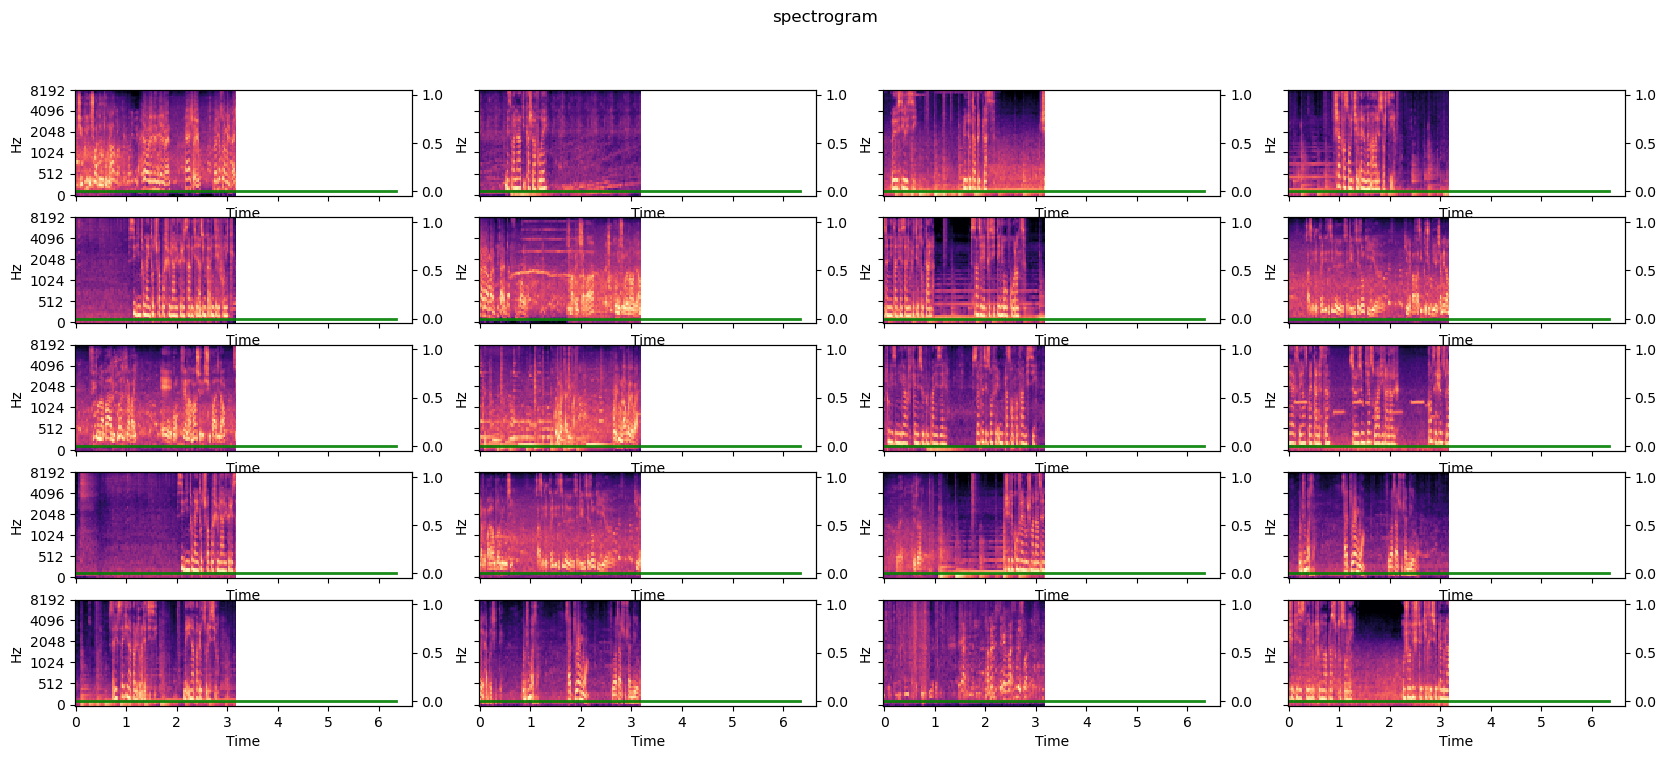

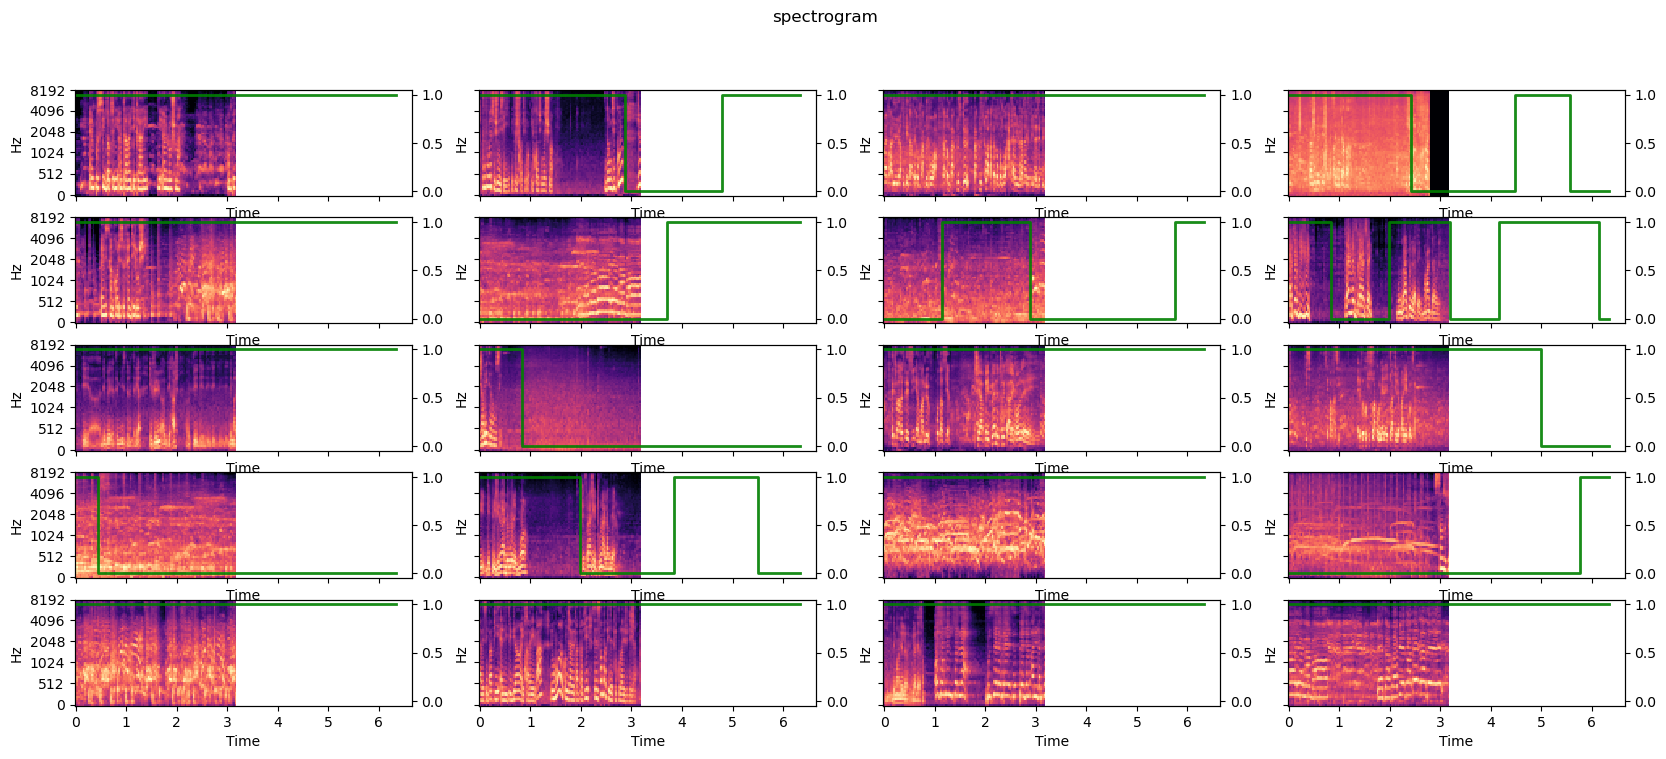

In [42]:

def plot_windows(wins, col_wrap=None, height=4, aspect=1, sr=16000):
    specs = wins.spectrogram
    
    nrow = 1
    ncol = len(specs)
    if col_wrap is not None:
        nrow = int(numpy.ceil(ncol / col_wrap))
        ncol = col_wrap

    fig_height = height * nrow
    fig_width = height * aspect * ncol
    fig, axs = plt.subplots(ncol, nrow, sharex=True, sharey=True, figsize=(fig_width, fig_height))
    axs = numpy.array(axs).flatten()
    
    fig.suptitle(specs.name)
    for ax, s, l in zip(axs, specs, wins.labels):
    
        l = numpy.squeeze(l)
        ll = pandas.DataFrame({
            'event': l,
            'time': pandas.to_timedelta(numpy.arange(l.shape[0])*hop_length/sr, unit='s'),
        })
        
        plot_spectrogram(ax, s, label_activations=ll)

windows.groupby('event').sample(n=20).groupby('event').apply(plot_windows, col_wrap=5, aspect=2, height=2)


In [150]:

def dataset_split_grouped(data, group, val_size=0.25, test_size=0.25, random_state=3, column='split'):
    """
    Split DataFrame into 3 non-overlapping parts: train,val,test
    with approximately the specified proportions

    Is splitted based on the group column
    
    Returns a new DataFrame with the rows marked by the assigned split in @column
    """
    train_size = (1.0 - val_size - test_size)

    rng = numpy.random.default_rng(random_state)
    
    groups = sorted(data[group].unique())
    rng.shuffle(groups)
    
    train_stop = int(len(groups) * train_size)
    val_stop = train_stop + int(len(groups)*val_size)
    
    print(train_stop, val_stop, len(groups))
    
    def with_group(groups):
        idx = data[data[group].isin(groups)].index
        return idx
    
    data = data.copy()
    data.loc[with_group(groups[0:train_stop]), column] = 'train'
    data.loc[with_group(groups[train_stop:val_stop]), column] = 'val'
    data.loc[with_group(groups[val_stop:-1]), column] = 'test'
    
    return data

ann = dataset_split_grouped(annotations.reset_index(), group='clip', val_size=0.15, test_size=0.15)
ann.split.value_counts()


112 136 160


train    27919
val       5923
test      5787
Name: split, dtype: int64

In [46]:

import tensorflow.keras
from microvad.models.sednet import build_sednet
from microvad.train.losses import weighted_binary_crossentropy

def build_model(input_shape, dropout=0.5, lr=0.01, class_weights=None):
    
    # Model
    model = build_sednet(input_shape, n_classes=1,
                         filters=10,
                         cnn_pooling=[2, 2, 2],
                         rnn_units=[5, 5],
                         dense_units=[16],
                         dropout=dropout,
                        )

    # Metrics
    pr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve="PR", name='pr_auc')
    precision = tensorflow.keras.metrics.Precision(name='precision')
    recall = tensorflow.keras.metrics.Recall(name='recall')
    
    # Loss
    if class_weights is None:
        loss = tensorflow.keras.losses.BinaryCrossentropy()
    else:
        loss = weighted_binary_crossentropy(*class_weights)
       
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=[pr_auc, precision, recall],
    )
    return model

model = build_model(input_shape=(window_length, 64, 1))
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 64, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 64, 10)       100       
                                                                 
 batch_normalization_6 (Batc  (None, 100, 64, 10)      400       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 100, 64, 10)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 32, 10)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 100, 32, 10)       0   

In [ ]:
epochs = 600
batch_size = 10*64

from tqdm.keras import TqdmCallback

# Compute the spectral background across entire clip
# Used for spectral subtraction, a type of preprocessing/normalization technique that is often useful
Xm = numpy.expand_dims(numpy.mean(numpy.concatenate([s.T for s in dataset.spectrogram]), axis=0), -1)

def get_XY(split):
    # convenience to convert
    d = dataset[dataset.split == split]
    
    X = numpy.expand_dims(numpy.stack([(s-Xm).T for s in d.spectrogram]), -1)

    Y = numpy.stack([ l.T for l in d.labels], axis=0)    
    return X, Y

train = get_XY(split='train')
val = get_XY(split='val')

def compute_class_weights(y_train):
    from sklearn.utils import class_weight
    y_train = numpy.squeeze(y_train).astype(int)
    y_train = numpy.any(y_train, axis=1)
    w = class_weight.compute_class_weight('balanced', classes=numpy.unique(y_train), y=y_train)
    #w_dict = dict(zip(numpy.unique(y_train), w))
    return w

class_weights = compute_class_weights(train[1])
#class_weights = None # disable class weights
print('Class weights', class_weights)

# make sure to stop when model does not improve anymore / starts overfitting
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
progress_bar = TqdmCallback()


model = build_model(input_shape=(window_length, 32, 1), dropout=0.10, lr=1*0.001, class_weights=class_weights)
hist = model.fit(x=train[0], y=train[1],
        validation_data=val,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            progress_bar,
            #lr_callback,
            #early_stop,
        ],
        verbose=False, # using progress bar callback instead
)

def plot_history(history):

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    history = pandas.DataFrame(hist.history)
    history.index.name = 'epoch'
    history.plot(ax=axs[0], y=['loss', 'val_loss'])
    history.plot(ax=axs[1], y=['pr_auc', 'val_pr_auc'])
    axs[1].set_ylim(0, 1.0)
    axs[1].axhline(0.80, ls='--', color='black', alpha=0.5)
    
    axs[0].axhline(0.10, ls='--', color='black', alpha=0.5)
    axs[0].set_ylim(0, 1.0)

plot_history(hist)
